# SDC Project 3: Build a Traffic Sign Recognition Classifier

### By Devin Datt     Due: August 31st, 2018

### Objective
Design and implement a deep learning model that learns to recognize traffic signs. I will  train and test my model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

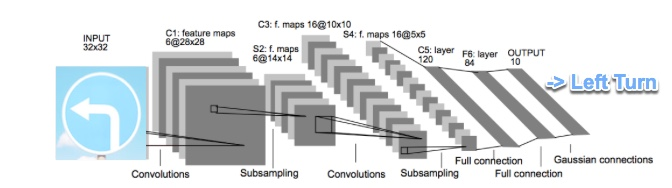

---
## Step 0: Load The Data

In [39]:
# Initial load of necessary imports
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import cv2
import tensorflow as tf
from sklearn.utils import shuffle    #Shuffle the training data

#Reading training and testing data from a pickle file
training_file = '/home/workspace/data/train.p'
validation_file= '/home/workspace/data/valid.p'
testing_file = '/home/workspace/data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set

In [40]:
ttl_samples = len(X_train) + len(X_valid) + len(X_test)

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# Number of validation examples
n_validation = len(X_valid)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(test['labels']))
#n_classes = len((test['labels']))

print("Total number of examples to use =", ttl_samples)
print("Number of training examples = {} ({}%)".format(n_train, int(n_train/ttl_samples*100)))
print("Number of testing examples = {} ({}%)".format(n_test, int(n_test/ttl_samples*100)))
print("Number of validation examples ={} ({}%)".format(n_validation, int(n_validation/ttl_samples*100)))
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Total number of examples to use = 51839
Number of training examples = 34799 (67%)
Number of testing examples = 12630 (24%)
Number of validation examples =4410 (8%)
Image data shape = (32, 32, 3)
Number of classes = 43


### Visual exploration of the dataset

Visualizing the German Traffic Signs Dataset using the pickled file(s). 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

In [41]:
### Data exploration visualization code

import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
y = np.bincount(y_train)
labels_pd = pd.read_csv('./signnames.csv', sep=',')
labels_pd

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


Video Hint: look at how many images of each in each class? Turns out some more then others and this can affect the accuracy of your model and its performance.

Video Hint: print out some of the images in each class, to see if you need to do any preprocessing of the images, clearing up, rotation... try normalizing all images (-127.5/255)

In [43]:
# Nearly 20% (8 categories) have more then 1500 traffic signs in them
y[y >1500]

array([1980, 2010, 1770, 1650, 1800, 1890, 1920, 1860])

In [44]:
# Nearly 50% (21 categories) have less then 500 traffic signs in them
y[y <500]

array([180, 360, 360, 180, 300, 270, 330, 450, 240, 210, 480, 240, 390,
       210, 360, 330, 180, 270, 300, 210, 210])

In [45]:
# Print the top 10 most frequent signs
from collections import Counter
x = Counter(y_train)
y = sorted(x.items(), key = lambda x: x[1], reverse=True)

for i in y[:10]:
    print('Sign : ',labels_pd['SignName'].loc[labels_pd['ClassId'] == i[0]])
    print('Appears : ',i[1], ' times.')
    print(  )

Sign :  2    Speed limit (50km/h)
Name: SignName, dtype: object
Appears :  2010  times.

Sign :  1    Speed limit (30km/h)
Name: SignName, dtype: object
Appears :  1980  times.

Sign :  13    Yield
Name: SignName, dtype: object
Appears :  1920  times.

Sign :  12    Priority road
Name: SignName, dtype: object
Appears :  1890  times.

Sign :  38    Keep right
Name: SignName, dtype: object
Appears :  1860  times.

Sign :  10    No passing for vehicles over 3.5 metric tons
Name: SignName, dtype: object
Appears :  1800  times.

Sign :  4    Speed limit (70km/h)
Name: SignName, dtype: object
Appears :  1770  times.

Sign :  5    Speed limit (80km/h)
Name: SignName, dtype: object
Appears :  1650  times.

Sign :  25    Road work
Name: SignName, dtype: object
Appears :  1350  times.

Sign :  9    No passing
Name: SignName, dtype: object
Appears :  1320  times.



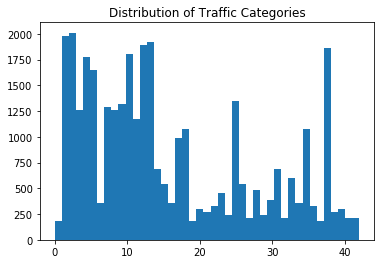

In [46]:
# Visualize the distribution of frequency the signs appear in dataset
plt.hist(y_train, bins=43);
plt.title('Distribution of Traffic Categories');

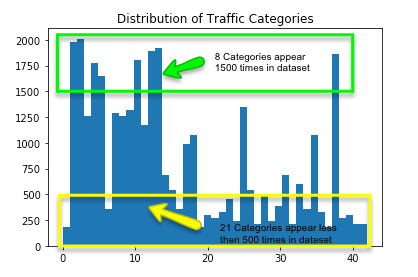

----

## Step 2: Design and Test a Model Architecture

Some of the aspects we considered when implementing the LeNet model for the purposes of builing a Traffic Sign classification were:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

### Pre-process the Data Set (normalization, grayscale, etc.)

To improve our chances for better accuracy on detecting the right traffic signs the data should be normalized so that the data has mean zero and equal variance. 

For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

In [47]:
# It is required to normalize the data. 
#Other preprocessing steps to clarify some of the darker images include:
#   - converting to grayscale
#   - Normalization 
#   - Histogram normalization

In [48]:
# Define a normalize & grayscale function for images

def normal_grey(x):
 
    x_greyscale = np.sum(x/3, axis=3, keepdims=True)
    x_norm = (x_greyscale - 128)/128 
    
    return x_norm

This sign is:  3    Speed limit (60km/h)
Name: SignName, dtype: object


(32, 32, 3)

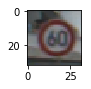

In [11]:
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

print('This sign is: ',labels_pd['SignName'].loc[labels_pd['ClassId'] == y_train[index]])
plt.figure(figsize=(1,1))
plt.imshow(image);
image.shape

This sign is:  3    Speed limit (60km/h)
Name: SignName, dtype: object


(32, 32)

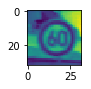

In [12]:
X_train_prime = normal_grey(X_train)
image = X_train_prime[index].squeeze()

print('This sign is: ',labels_pd['SignName'].loc[labels_pd['ClassId'] == y_train[index]])
plt.figure(figsize=(1,1))
plt.imshow(image);
image.shape

In [13]:
X_train_prime.shape

(34799, 32, 32, 1)

This sign is:  7    Speed limit (100km/h)
Name: SignName, dtype: object


(32, 32)

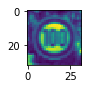

In [14]:
index = random.randint(0, len(X_valid))
X_valid_prime = normal_grey(X_valid)
image = X_valid_prime[index].squeeze()

print('This sign is: ',labels_pd['SignName'].loc[labels_pd['ClassId'] == y_valid[index]])
plt.figure(figsize=(1,1))
plt.imshow(image);
image.shape

In [15]:
X_valid_prime.shape

(4410, 32, 32, 1)

This sign is:  15    No vehicles
Name: SignName, dtype: object


(32, 32)

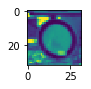

In [16]:
index = random.randint(0, len(X_test))
X_test_prime = normal_grey(X_test)
image = X_test_prime[index].squeeze()

print('This sign is: ',labels_pd['SignName'].loc[labels_pd['ClassId'] == y_test[index]])
plt.figure(figsize=(1,1))
plt.imshow(image);
image.shape

In [17]:
X_test_prime.shape

(12630, 32, 32, 1)

In [56]:
# Shuffling all the datasets
X_train_prime, y_train = shuffle(X_train_prime, y_train)
X_valid_prime, y_valid = shuffle(X_valid_prime, y_valid)
X_test_prime, y_test = shuffle(X_test_prime, y_test)

### Model Architecture

We will define the convolution neural network here. I chose to use the LeNet model as starter code. The reason is this CNN model is good for statistical invariance (ie. images on one side of the screen are the same as the other).

I used the basic LeNet CNN architecture and modified by adding dropouts around each ReLU activation function and changed the numbers of the 'fully connected layers'.

In [67]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
#    x = normal_grey(x)
        
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
#    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
#    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(tf.nn.relu(conv1), keep_prob)


    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    ksize=[1, 2, 2, 1]
    strides=[1, 2, 2, 1]
    padding='VALID'
#    conv1 = tf.nn.max_pool(conv1, ksize, strides, padding)
    conv1 = tf.nn.dropout(tf.nn.max_pool(conv1, ksize, strides, padding), keep_prob)

    
    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    
    # SOLUTION: Activation.
#    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(tf.nn.relu(conv2), keep_prob)


    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    ksize=[1, 2, 2, 1]
    strides=[1, 2, 2, 1]
    padding='VALID'
#    conv2 = tf.nn.max_pool(conv2, ksize, strides, padding)
    conv2 = tf.nn.dropout(tf.nn.max_pool(conv2, ksize, strides, padding), keep_prob)

    
    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
#    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(tf.nn.relu(fc1), keep_prob)


    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
#    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(tf.nn.relu(fc2), keep_prob)


    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Features and Labels

Here we will define our variable placeholders for that is be used as our inputs and outputs:

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

In [68]:
# Define placeholder for batch input (x) and output (y)
# Define the final 43 one hot encodings we need to our probabilities to fall into at the end

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
#x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

keep_prob = tf.placeholder(tf.float32)    #Used for Dropout rates

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [69]:
# Here we will train the model, calculate and report the accuracy on the 
# training and validation set.

# After model is selected the accuracy on the test set was calculated 
# and reported below.

In [74]:
#Define initial tensorflow settings

EPOCHS = 20
BATCH_SIZE = 128
rate = 0.0001

In [75]:
#CNN pipeline

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [76]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model

Here we run the training data through the training pipeline created above to train the model.

Before each epoch, we shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

In [79]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
#    num_examples = len(X_train)
    num_examples = len(X_train_prime)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
#        X_train, y_train = shuffle(X_train, y_train)
        X_train_prime, y_train = shuffle(X_train_prime, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_prime[offset:end], y_train[offset:end]
#            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.9})
        validation_accuracy = evaluate(X_valid_prime, y_valid)
#        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './traffic')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.054

EPOCH 2 ...
Validation Accuracy = 0.053

EPOCH 3 ...
Validation Accuracy = 0.050

EPOCH 4 ...
Validation Accuracy = 0.051

EPOCH 5 ...
Validation Accuracy = 0.052

EPOCH 6 ...
Validation Accuracy = 0.053

EPOCH 7 ...
Validation Accuracy = 0.055

EPOCH 8 ...
Validation Accuracy = 0.057

EPOCH 9 ...
Validation Accuracy = 0.056

EPOCH 10 ...
Validation Accuracy = 0.056

EPOCH 11 ...
Validation Accuracy = 0.054

EPOCH 12 ...
Validation Accuracy = 0.055

EPOCH 13 ...
Validation Accuracy = 0.055

EPOCH 14 ...
Validation Accuracy = 0.059

EPOCH 15 ...
Validation Accuracy = 0.055

EPOCH 16 ...
Validation Accuracy = 0.059

EPOCH 17 ...
Validation Accuracy = 0.057

EPOCH 18 ...
Validation Accuracy = 0.058

EPOCH 19 ...
Validation Accuracy = 0.056

EPOCH 20 ...
Validation Accuracy = 0.061

Model saved


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

## Resources

Normalize RGB Pixels:
https://stackoverflow.com/questions/48785115/numpy-normalize-rgb-pixel-array

